In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join('..')))

In [278]:
from typing import List

import time 
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch import Tensor, einsum
from einops import parse_shape, rearrange, repeat

np.set_printoptions(precision=3, edgeitems=20, linewidth=250)
torch.set_printoptions(precision=3, edgeitems=20, linewidth=250)

def count_parameters(model: nn.Module):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def count_parameters_all(model: nn.Module):
    return sum(p.numel() for p in model.parameters())

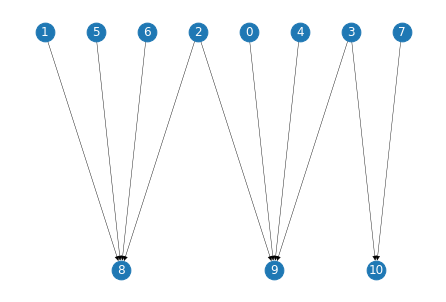

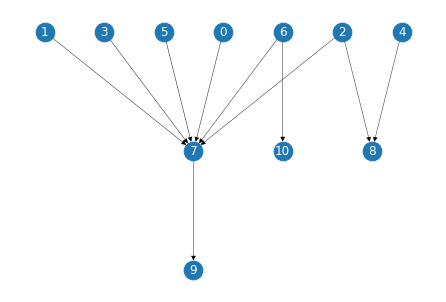

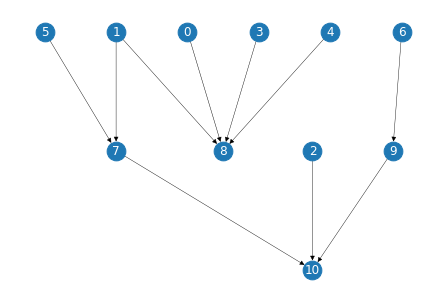

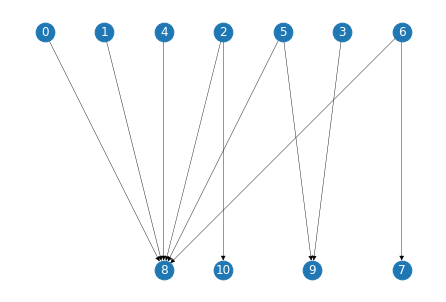

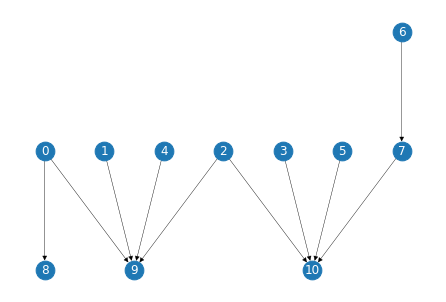

torch.Size([5, 5, 11])


In [335]:
import matplotlib.pyplot as plt
import networkx as nx
import pydot
from itertools import product
from networkx.drawing.nx_pydot import graphviz_layout

class Treegram(nn.Module):
    
    def __init__(
        self, 
        num_features: int, 
        block_size: int,
        debug: bool = False
    ):
        super().__init__()
        self.num_features = num_features
        self.block_size = block_size
        self.debug = debug
        self.scale = num_features ** -0.5
        # Deepest possible tree with n leaves has n-1 nodes
        self.num_base_nodes = block_size
        self.num_extra_nodes = self.num_base_nodes - 1
        self.num_nodes = self.num_base_nodes + self.num_extra_nodes
    
        self.to_z = nn.Linear(
            in_features=self.num_base_nodes, 
            out_features=self.num_extra_nodes
        )
        self.to_q = nn.Linear(
            in_features=num_features, 
            out_features=num_features
        )
        self.to_k = nn.Linear(
            in_features=num_features, 
            out_features=num_features
        )
        self.to_v = nn.Linear(
            in_features=num_features, 
            out_features=num_features
        )
        
    def forward(self, x: Tensor) -> Tensor:
        b, n, c = x.shape
        # Dimensionality checks
        message = "Expected input of shape [b, block_size, num_features]"
        assert n == self.block_size, message
        assert c == self.num_features, message
        # Compute extra tokens 
        z = rearrange(x, 'b n c -> b c n')
        z = self.to_z(z)
        z = rearrange(z, 'b c n -> b n c')
        # Concatenate all tokens 
        xz = torch.cat([x, z], dim = 1)
        # Only extra tokens make queries (we don't care about input token relations)
        q = self.to_q(z)
        # All nodes are used for keys 
        k = self.to_k(xz)
        # Compute similarity to get tree adjacency matrix 
        sim = einsum('b i l, b j l -> b i j', q, k) * self.scale 
        # Move towards a single connection per node 
        att = sim.softmax(dim = 1)
        att_sparse = torch.zeros_like(att)
        # Make attention sparse by maximum spanning tree
        for i in range(b):  
            graph = self.tensor_to_graph(att[i])
            tree = nx.maximum_spanning_tree(graph)
            att_sparse[i] = self.graph_to_tensor(tree)
            self.debug and self.plot_graph(tree)
        # Copy gradients to att 
        att_sparse = att + (att_sparse - att).detach() 
        
        return att_sparse
    
    def tensor_to_graph(self, x: Tensor) -> nx.Graph:
        num_extra_nodes, num_nodes = x.shape
        # Build graph with `num_nodes` nodes
        graph = nx.Graph()
        graph.add_nodes_from(range(num_nodes))
        # Build edge triplets (source, target, weight)
        edges = product(range(num_extra_nodes), range(num_nodes))
        triples = ((u + self.num_base_nodes, v, dict(weight = x[u, v])) for u, v in edges)
        graph.add_edges_from(triples)
        return graph         
        
    def graph_to_tensor(self, graph: nx.Graph) -> Tensor:
        x = torch.zeros((self.num_extra_nodes, self.num_nodes))
        for u, v, data in graph.edges(data = True):
            w = data['weight']
            if u < self.num_base_nodes:
                x[v-self.num_base_nodes, u] = w
            else:
                x[u-self.num_base_nodes, v] = w
        return x
    
    def plot_graph(self, graph: nx.Graph) -> None:
        options = { 
            "node_size": 350, 
            "arrows": True, 
            "with_labels": True, 
            "font_color": 'white'
        }
        pos = graphviz_layout(graph, prog='dot')
        weights = [graph[u][v]['weight']*2 for u,v in graph.edges()]
        nx.draw(graph, pos, width = weights, **options)
        plt.show()


block_size = 6
num_features = 64

block = Treegram(
    num_features = num_features,
    block_size = block_size,
    debug = True
)

x = torch.rand(5, block_size, num_features)
out = block(x)
print(out.shape)

In [329]:
labels = {
    0: 'a',
    1: 'b',
    2: 'c'
}
options = { 
            "node_size": 350, 
            "alpha": 1.0, 
            "arrows": True, 
            "with_labels": True, 
            "font_color": 'white', 
            #"labels": labels 
        }
#labels = nx.get_edge_attributes(tree_nx, 'weight')
#nx.draw_networkx_edge_labels(tree_nx, pos, edge_labels=labels)
#print(pos)